In [2]:
# GOAL: fit KNN, RF, and XGBOOST, including hyperparameter tuning
# and assess based on (r)mse and R^2.

In [3]:
# installs and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as skm
import xgboost
from xgboost import XGBRegressor

In [4]:
# import train and test data
Xtrain_filled = pd.read_csv("./saved_data/Xtrain_filled.csv",index_col="School Name")
ytrain = pd.read_csv("./saved_data/ytrain.csv",index_col="School Name").squeeze()
Xtest_filled = pd.read_csv("./saved_data/Xtest_filled.csv",index_col="School Name") # note: filled test set is from Xtest0
ytest0 = pd.read_csv("./saved_data/ytest.csv",index_col="School Name").squeeze()

# 10 year post entry data
Xtrain_filled10 = pd.read_csv("./saved_data/Xtrain_filled10.csv",index_col="School Name")
ytrain10 = pd.read_csv("./saved_data/ytrain10.csv",index_col="School Name").squeeze()
Xtest_filled10 = pd.read_csv("./saved_data/Xtest_filled10.csv",index_col="School Name") # note: filled test set is from Xtest0
ytest10 = pd.read_csv("./saved_data/ytest10.csv",index_col="School Name").squeeze()

,Full-time Faculty Rate (%),Faculty Average Salary,Student Enrollment Size,Attendance Cost,Completion Rate,Admission Rate (%),Retention Rate,SAT Average,Ivy League Plus,x0_Private ForProfit,x0_Private NonProfit,x0_Public
School Name,,,,,,,,,,,,
Saginaw Valley State University,50.28,101148.0,6953.0,22353.0,47.88,89.460000,77.37,1086.000000,0.0,0.0,0.0,1.0
Centre College,93.20,99564.0,1333.0,56645.0,83.16,72.080000,89.30,1325.000000,0.0,0.0,1.0,0.0
SUNY Empire State College,22.53,89832.0,8221.0,19726.0,27.03,80.041536,64.91,1116.619148,0.0,0.0,0.0,1.0
Boise Bible College,90.00,54900.0,94.0,24258.0,38.64,90.380000,66.67,988.000000,0.0,0.0,1.0,0.0
West Coast University-Dallas,25.56,88980.0,1182.0,27991.0,100.00,73.095845,0.00,1097.854469,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Covenant College,100.00,93840.0,842.0,49420.0,67.55,97.550000,84.47,1209.000000,0.0,0.0,1.0,0.0
South University-Tampa,33.03,82896.0,548.0,28397.0,13.04,89.200352,50.00,1056.432851,0.0,1.0,0.0,0.0
The College of Saint Scholastica,53.38,84516.0,2225.0,50923.0,68.63,73.310000,83.52,1205.000000,0.0,0.0,1.0,0.0


## KNN Regression

In [93]:
knn0 = KNeighborsRegressor()
knn0.fit(Xtrain_filled,ytrain)

KNeighborsRegressor()

In [94]:
np.arange(4,20,1)

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [95]:
# set parms for hyperparameter tuning
parms = {
    "n_neighbors": np.arange(4,20,1),
    "weights": ["uniform","distance"]
}
knn = KNeighborsRegressor() # initialize knn
gc_knn = GridSearchCV(estimator=knn,param_grid=parms, cv = 10,
                      scoring = "neg_root_mean_squared_error")

In [96]:
# fit/run gcv for knn
gc_knn.fit(Xtrain_filled,ytrain)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [112]:
print(gc_knn.best_params_)
print(-gc_knn.best_score_/np.std(ytrain))
cv_knn_results = pd.concat([pd.DataFrame(gc_knn.cv_results_["params"]),pd.DataFrame(gc_knn.cv_results_["mean_test_score"], columns=["neg_root_mean_squared_error"])],axis=1)
cv_knn_res_dist = cv_knn_results[cv_knn_results.weights == "distance"]
cv_knn_res_dist

{'n_neighbors': 18, 'weights': 'distance'}
0.7562243376739706


,n_neighbors,weights,neg_root_mean_squared_error
1,4,distance,-9395.155982
3,5,distance,-9172.861028
5,6,distance,-9025.694583
7,7,distance,-8979.078750
9,8,distance,-8967.291555
11,9,distance,-8894.034358
13,10,distance,-8803.637321
15,11,distance,-8760.532256
17,12,distance,-8742.306967
19,13,distance,-8726.746921


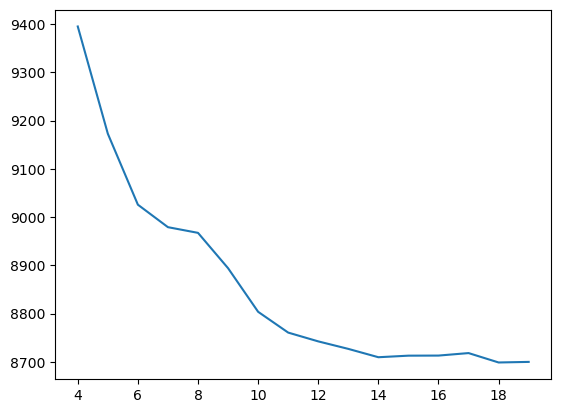

In [113]:
plt.plot(cv_knn_res_dist.n_neighbors,-cv_knn_res_dist.neg_root_mean_squared_error)

In [120]:
# base on elbow point, it appears 7 or 14 should be a good number of nearest neighbors
# any more will likely lead to overfitting
best_knn = KNeighborsRegressor(n_neighbors= 14, weights= 'distance').fit(Xtrain_filled,ytrain)
best_knn

KNeighborsRegressor(n_neighbors=14, weights='distance')

In [122]:
# metrics
print("Train R^2:", skm.r2_score(ytrain,best_knn.predict(Xtrain_filled)))
print("Train RMSE:", np.sqrt(skm.mean_squared_error(ytrain,best_knn.predict(Xtrain_filled))))
print("Train Scaled RMSE:", np.sqrt(skm.mean_squared_error(ytrain,best_knn.predict(Xtrain_filled)))/np.std(ytrain))

print("Test R^2:", skm.r2_score(ytest0,best_knn.predict(Xtest_filled)))
print("Test RMSE:", np.sqrt(skm.mean_squared_error(ytest0,best_knn.predict(Xtest_filled))))
print("Test Scaled RMSE:", np.sqrt(skm.mean_squared_error(ytest0,best_knn.predict(Xtest_filled)))/np.std(ytest0))
# admittedly chose 14 becase improve oos fit
# clear overfitting whether 7 or 14 nearest neighbors used.

Train R^2: 1.0
Train RMSE: 0.0
Train Scaled RMSE: 0.0
Test R^2: 0.45119394448261163
Test RMSE: 8221.811501578883
Test Scaled RMSE: 0.7408144541768797


Extreme overfitting shown by in vs. out of sample performance of KNN

## Random Forest

In [124]:
rf = RandomForestRegressor(criterion="squared_error")
rf_parms = {
    "n_estimators": [100,150,200,250],
    "max_features": ["sqrt","log2",1.0],
    # preliminary tuning showed default values consistently best
    # "min_samples_split": [2, 5], 
    # "min_samples_leaf": [1, 2],
}

In [136]:
gcv_rf_mse = GridSearchCV(rf,param_grid=rf_parms,cv = 5,
                          scoring = "neg_mean_squared_error")

In [137]:
gcv_rf_r2 = GridSearchCV(rf,param_grid=rf_parms,cv = 5,
                         scoring = "r2")

In [138]:
# perform grid search cv both optimizing r2 and minimizing mse
gcv_rf_mse.fit(Xtrain_filled,ytrain) 
# took 4 minutes to run 2 cvs
# 17 to run 5
# 2 min to run when only 3 n_estimators, and then the max features options

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['sqrt', 'log2', 1.0],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='neg_mean_squared_error')

In [139]:
gcv_rf_mse.best_params_

{'max_features': 'sqrt', 'n_estimators': 250}

In [140]:
# make a table of cv results
# based on code from stack overflow response (https://stackoverflow.com/questions/58835592/result-of-gridsearchcv-as-table)
cv_mse_results = pd.concat([pd.DataFrame(gcv_rf_mse.cv_results_["params"]),pd.DataFrame(gcv_rf_mse.cv_results_["mean_test_score"], columns=["neg_mean_squared_error"])],axis=1)
cv_mse_results["RMSE"] = round(np.sqrt(-cv_mse_results["neg_mean_squared_error"]),2)
cv_mse_results

,max_features,n_estimators,neg_mean_squared_error,RMSE
0,sqrt,100,-6.332458e+07,7957.67
1,sqrt,150,-6.187903e+07,7866.32
2,sqrt,200,-6.207050e+07,7878.48
3,sqrt,250,-6.170995e+07,7855.57
4,log2,100,-6.274114e+07,7920.93
5,log2,150,-6.321983e+07,7951.09
6,log2,200,-6.343043e+07,7964.32
7,log2,250,-6.205432e+07,7877.46
8,1.0,100,-6.565842e+07,8102.99
9,1.0,150,-6.644790e+07,8151.56


In [141]:
gcv_rf_r2.fit(Xtrain_filled,ytrain)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['sqrt', 'log2', 1.0],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='r2')

In [142]:
gcv_rf_r2.best_params_

{'max_features': 'sqrt', 'n_estimators': 200}

In [143]:
cv_r2_results = pd.concat([pd.DataFrame(gcv_rf_r2.cv_results_["params"]),pd.DataFrame(gcv_rf_r2.cv_results_["mean_test_score"], columns=["r2"])],axis=1)
cv_r2_results["r2"] = round(cv_r2_results["r2"],3)
cv_r2_results

,max_features,n_estimators,r2
0,sqrt,100,0.527
1,sqrt,150,0.523
2,sqrt,200,0.530
3,sqrt,250,0.529
4,log2,100,0.514
5,log2,150,0.530
6,log2,200,0.526
7,log2,250,0.523
8,1.0,100,0.494
9,1.0,150,0.496


Both models appeared to have better results when changing the `max_features` hyperparameter from the default of 1.0. max_features = `sqrt` with 250 estimators appeaed to hvae the lowest average RMSE, and had comparable R^2. therefore, I selected these hyperparameters to fit my final random forest model.

In [144]:
# fit model with best parms
best_rf = RandomForestRegressor(n_estimators=250, max_features="sqrt",
                                criterion="squared_error").fit(Xtrain_filled,ytrain)

In [145]:
# assess fit
# metrics
print("Train R^2:", skm.r2_score(ytrain,best_rf.predict(Xtrain_filled)))
print("Train RMSE:", np.sqrt(skm.mean_squared_error(ytrain,best_rf.predict(Xtrain_filled))))
print("Train Scaled RMSE:", np.sqrt(skm.mean_squared_error(ytrain,best_rf.predict(Xtrain_filled)))/np.std(ytrain))

print("Test R^2:", skm.r2_score(ytest0,best_rf.predict(Xtest_filled)))
print("Test RMSE:", np.sqrt(skm.mean_squared_error(ytest0,best_rf.predict(Xtest_filled))))
print("Test Scaled RMSE:", np.sqrt(skm.mean_squared_error(ytest0,best_rf.predict(Xtest_filled)))/np.std(ytest0))

Train R^2: 0.9366028127074306
Train RMSE: 2896.2279510814606
Train Scaled RMSE: 0.2517879808342117
Test R^2: 0.5680374591000121
Test RMSE: 7294.257856919
Test Scaled RMSE: 0.65723857228558


## CATBOOST
A nice perk of cat boost: it looks like it may allow you to specify which predictors are categorical, and will do (one-hot) encoding for you. Can try it both ways and see if performance differs significantly.

However, after performing some research, it seems like this is a better method for cateogorical data, and especially for classification tasks

## XGBOOST

In [135]:
# reminders of dimensions
print("Num Features:", len(Xtrain_filled.columns)) # num independent variables (input features)
np.sqrt(len(Xtrain_filled.columns))
# sqrt of this: which is the rule used in best RF

Num Features: 12


3.4641016151377544

In [35]:
print(xgboost.__version__)

2.0.1


In [55]:
xgb = XGBRegressor(eval_metric = "rmse",
                   n_estimators = 500)

In [72]:
# original tuning
xgb_parms = {
    "max_depth": [4,5,6],
    "colsample_bytree": [0.4,0.5,0.6] , # similar to max_features in RF
    "learning_rate": [0.1, 0.2,0.3] # AKA eta
}

In [66]:
from sklearn.model_selection import RepeatedKFold

In [68]:
rcv = RepeatedKFold(n_splits=5,n_repeats=5)

In [73]:
# grid search cv
gcv_xgb = GridSearchCV(xgb, param_grid=xgb_parms,
                       cv = rcv, scoring = "neg_mean_squared_error")

In [74]:
# fit grid search cv
gcv_xgb.fit(Xtrain_filled,ytrain)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_typ...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=500,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6]},
             scoring='neg_mean_squared_error')

In [75]:
# best parms
gcv_xgb.best_params_

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 6}

In [61]:
# best parms
gcv_xgb.best_params_
# original 5 fold cv best: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 6}

{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 6}

In [76]:
# print cv results
xcv_mse_results = pd.concat([pd.DataFrame(gcv_xgb.cv_results_["params"]),pd.DataFrame(gcv_xgb.cv_results_["mean_test_score"], columns=["neg_mean_squared_error"])],axis=1)
xcv_mse_results["RMSE"] = round(np.sqrt(-xcv_mse_results["neg_mean_squared_error"]),2)
xcv_mse_results.iloc[:, [0,1,2,4]]

,colsample_bytree,learning_rate,max_depth,RMSE
0,0.4,0.1,4,8324.88
1,0.4,0.1,5,8323.55
2,0.4,0.1,6,8270.85
3,0.4,0.2,4,8472.61
4,0.4,0.2,5,8432.54
5,0.4,0.2,6,8455.76
6,0.4,0.3,4,8629.90
7,0.4,0.3,5,8592.66
8,0.4,0.3,6,8517.31
9,0.5,0.1,4,8274.57


In [133]:
# focused tune
# grid search cv
xgb_parms = {
    "max_depth": [6],
    "colsample_bytree": [0.5] , # similar to max_features in RF
    "learning_rate": [0.005,0.01] # AKA eta
}

gcv_xgb2 = GridSearchCV(xgb, param_grid=xgb_parms,
                        cv = rcv, scoring = "neg_mean_squared_error")

gcv_xgb2.fit(Xtrain_filled,ytrain)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_typ...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=500,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.5],
                         'learning_rate': [0.005, 0.01], 'max_depth': [6]},
             scoring='neg_mean_squared_error')

In [146]:
print("best parms:",gcv_xgb2.best_params_)
np.sqrt(-gcv_xgb2.best_score_)

best parms: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 6}


7997.43421204739

In [147]:
# fit best xgb
best_xgb = XGBRegressor(n_estimators = 500,
                        eval_metric = "rmse",
                        max_depth = 6,
                        colsample_bytree= 0.5, # similar to max_features in RF
                        learning_rate= 0.01
                        ).fit(Xtrain_filled,ytrain)

In [148]:
# assess performance
# assess fit
# metrics
print("Train R^2:", skm.r2_score(ytrain,best_xgb.predict(Xtrain_filled)))
print("Train RMSE:", np.sqrt(skm.mean_squared_error(ytrain,best_xgb.predict(Xtrain_filled))))
print("Train Scaled RMSE:", np.sqrt(skm.mean_squared_error(ytrain,best_xgb.predict(Xtrain_filled)))/np.std(ytrain))

print("Test R^2:", skm.r2_score(ytest0,best_xgb.predict(Xtest_filled)))
print("Test RMSE:", np.sqrt(skm.mean_squared_error(ytest0,best_xgb.predict(Xtest_filled))))
print("Test Scaled RMSE:", np.sqrt(skm.mean_squared_error(ytest0,best_xgb.predict(Xtest_filled)))/np.std(ytest0))


Train R^2: 0.8843551170600976
Train RMSE: 3911.658710312947
Train Scaled RMSE: 0.34006599791790754
Test R^2: 0.5554049900887972
Test RMSE: 7400.147228304336
Test Scaled RMSE: 0.6667795812044657


With the best out of sample performance, and with less parameters needing to be tuned, I select a random forest model with chosen tuned hyperparameters specified above as my model going forward.